# Baseline Modeling - Regression

---

* Goal: to develop baseline models prior to feature engineering to compare performance vs. post-engineered models.

---

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns


In [26]:
## SKLearn and Modeling Tools

from sklearn import metrics
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, RidgeCV, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(transform_output='pandas')

from xgboost import XGBRegressor

## Load Data

In [27]:
df_data_h1 = pd.read_csv('../../data/source/H1.csv')
df_data_h1['HotelNumber'] = 'H1'

df_data_h2 = pd.read_csv('../../data/source/H2.csv')
df_data_h2['HotelNumber'] = 'H2'

df_data_full = pd.concat([df_data_h1,df_data_h2])

df_data_full

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelNumber
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,H1
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01,H1
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,H1
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02,H1
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03,H1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,H2
79326,0,102,2017,August,35,31,2,5,3,0.0,...,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,H2
79327,0,34,2017,August,35,31,2,5,2,0.0,...,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,H2
79328,0,109,2017,August,35,31,2,5,2,0.0,...,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,H2


## Set Target Feature

In [28]:
target_feature = 'ADR'

## Quick Overview

In [29]:
df_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119390 entries, 0 to 79329
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IsCanceled                   119390 non-null  int64  
 1   LeadTime                     119390 non-null  int64  
 2   ArrivalDateYear              119390 non-null  int64  
 3   ArrivalDateMonth             119390 non-null  object 
 4   ArrivalDateWeekNumber        119390 non-null  int64  
 5   ArrivalDateDayOfMonth        119390 non-null  int64  
 6   StaysInWeekendNights         119390 non-null  int64  
 7   StaysInWeekNights            119390 non-null  int64  
 8   Adults                       119390 non-null  int64  
 9   Children                     119386 non-null  float64
 10  Babies                       119390 non-null  int64  
 11  Meal                         119390 non-null  object 
 12  Country                      118902 non-null  object 
 13  Marke

In [30]:
df_data_full.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
IsCanceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
LeadTime,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
ArrivalDateYear,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
ArrivalDateWeekNumber,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
ArrivalDateDayOfMonth,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
StaysInWeekendNights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
StaysInWeekNights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
Adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
Children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
Babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [31]:
df_data_full.describe(exclude = 'number').T

,count,unique,top,freq
ArrivalDateMonth,119390,12,August,13877
Meal,119390,5,BB,92310
Country,118902,177,PRT,48590
MarketSegment,119390,8,Online TA,56477
DistributionChannel,119390,5,TA/TO,97870
ReservedRoomType,119390,10,A,85994
AssignedRoomType,119390,12,A,74053
DepositType,119390,3,No Deposit,104641
Agent,119390,334,9,31961
Company,119390,353,NULL,112593


In [32]:
target_feature = 'ADR'

In [33]:
df_data_full[target_feature].describe()

count    119390.000000
mean        101.831122
std          50.535790
min          -6.380000
25%          69.290000
50%          94.575000
75%         126.000000
max        5400.000000
Name: ADR, dtype: float64

# Train-Test Split and Preprocessor

In [34]:
df_data_full.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,HotelNumber
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,H1
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,H1
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,H1
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,H1


In [35]:
X = df_data_full.drop(columns = target_feature)
y = df_data_full[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 903)

# Pipeline

## DummyRegressor

In [36]:
### ---  Creating ColumnTransformer and sub-transformers for imputation and encoding --- ###
num_cols = X.select_dtypes('number').columns
cat_cols = X.select_dtypes('object').columns

cat_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
                           ('ohe',OneHotEncoder(drop = 'if_binary',
                                          handle_unknown='ignore',
                                          sparse_output=False))])

num_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
                           ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
                                               ('cat', cat_pipe, cat_cols)])

# Integrating the preprocessor with the DummyRegressor into a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', DummyRegressor())])

pipeline.fit(X_train, y_train)


preds = pipeline.predict(X_test)
mae = metrics.mean_absolute_error(y_test, preds)
rmse = metrics.root_mean_squared_error(y_test, preds)
r2 = metrics.r2_score(y_test, preds)

print(f'\nThe MAE is: {mae:.2f}',
      f'\nThe RMSE is: {rmse:.2f}'
      f'\nThe R2 is: {r2:.2f}')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 6, 8, 9, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



The MAE is: 36.36 
The RMSE is: 48.23
The R2 is: -0.00


## SGDRegressor

In [37]:
### ---  Creating ColumnTransformer and sub-transformers for imputation and encoding --- ###
num_cols = X.select_dtypes('number').columns
cat_cols = X.select_dtypes('object').columns

cat_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
                           ('ohe',
                            OneHotEncoder(drop = 'if_binary',
                                          handle_unknown='ignore',
                                          sparse_output=False))])

num_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
                           ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
                                               ('cat', cat_pipe, cat_cols)])

# Integrating the preprocessor with the SGDRegressor into a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', SGDRegressor(loss='huber',
                                                      penalty='elasticnet',
                                                      random_state=903))])

pipeline.fit(X_train, y_train)


preds = pipeline.predict(X_test)
mae = metrics.mean_absolute_error(y_test, preds)
rmse = metrics.root_mean_squared_error(y_test, preds)
r2 = metrics.r2_score(y_test, preds)

print(f'\nThe MAE is: {mae:.2f}',
      f'\nThe RMSE is: {rmse:.2f}'
      f'\nThe R2 is: {r2:.2f}')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 6, 8, 9, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



The MAE is: 23.43 
The RMSE is: 35.43
The R2 is: 0.46


## HGBRegressor

In [60]:
### ---  Creating ColumnTransformer and sub-transformers for imputation and encoding --- ###
num_cols = X.select_dtypes('number').columns
cat_cols = X.select_dtypes('object').columns

cat_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
                           ('ohe',
                            OneHotEncoder(drop = 'if_binary',
                                          handle_unknown='ignore',
                                          sparse_output=False))])

num_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
                           ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
                                               ('cat', cat_pipe, cat_cols)])

# Integrating the preprocessor with the HistGradientBoostingRegressor into a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', HistGradientBoostingRegressor(random_state=903))])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
mae = metrics.mean_absolute_error(y_test, preds)
rmse = metrics.root_mean_squared_error(y_test, preds)
r2 = metrics.r2_score(y_test, preds)

print(f'\nThe MAE is: {mae:.2f}',
      f'\nThe RMSE is: {rmse:.2f}'
      f'\nThe R2 is: {r2:.2f}')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 6, 8, 9, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



The MAE is: 11.56 
The RMSE is: 18.13
The R2 is: 0.86


## RandomForestRegressor

In [57]:
### ---  Creating ColumnTransformer and sub-transformers for imputation and encoding --- ###
num_cols = X.select_dtypes('number').columns
cat_cols = X.select_dtypes('object').columns

cat_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
                           ('ohe',
                            OneHotEncoder(drop = 'if_binary',
                                          handle_unknown='ignore',
                                          sparse_output=False))])

num_pipe = Pipeline(steps=[('cat_imp', SimpleImputer(strategy = 'most_frequent')),
                           ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
                                               ('cat', cat_pipe, cat_cols)])

# Integrating the preprocessor with the RandomForestRegressor into a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_jobs = -1,
                                                               min_samples_leaf = 2,
                                                               max_depth = 75,
                                                               random_state=903))])

pipeline.fit(X_train, y_train)

preds = pipeline.predict(X_test)
mae = metrics.mean_absolute_error(y_test, preds)
rmse = metrics.root_mean_squared_error(y_test, preds)
r2 = metrics.r2_score(y_test, preds)

print(f'\nThe MAE is: {mae:.2f}',
      f'\nThe RMSE is: {rmse:.2f}'
      f'\nThe R2 is: {r2:.2f}')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 6, 8, 9, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



The MAE is: 7.21 
The RMSE is: 17.77
The R2 is: 0.86


76

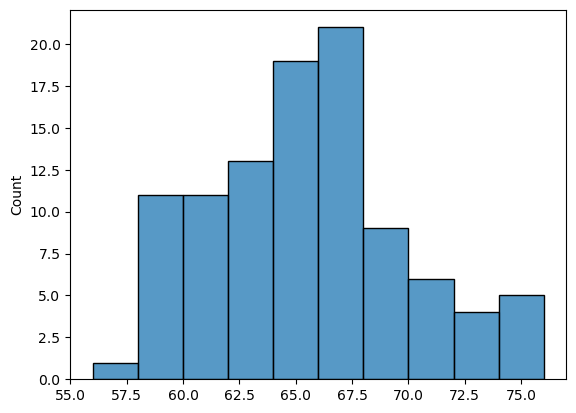

In [53]:
depths = [tree.get_depth() for tree in pipeline[-1].estimators_]

sns.histplot(depths)

In [55]:

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(random_state=903))])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'regressor__max_depth': [55, 65],               
    'regressor__min_samples_leaf': [2, 3]                  
}

# Integrate GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_  # Best score according to the refit metric

# Print the results
print("Best Parameters:", best_params)
print("Best Mean Absolute Error (MAE):", best_score)

KeyboardInterrupt: 

# XGBRegressor

In [24]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:,.2f}",)
print(f"Mean Squared Error (MSE): {mse:,.2f}",)
print(f"R-squared (R²): {r2:,.2f}")

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 6, 8, 9, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mean Absolute Error (MAE): 10.81
Mean Squared Error (MSE): 304.84
R-squared (R²): 0.87
